In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet
import torchvision.models as models

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GoogleNet（Inception v1）モデルを事前学習済みモデルとしてロード
model = models.googlenet(pretrained=True)

# GoogleNetの最終層の入力特徴量数を取得
num_ftrs = model.fc.in_features

# 最終層を4クラスの出力に変更
model.fc = nn.Linear(num_ftrs, 4)

# すべての層を訓練可能に設定
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)
print(model)

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [3]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/train')  #学習用データ：データ数は560
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/test') 

transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [4]:
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [5]:
# Train
def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100  
    patience = 10
    trigger_times = 0

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [6]:
#validation

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)

In [7]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['Normal lymph node', 'MALT lymphoma', 'GCB', 'Non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.905 acc: 61.387
The current loss: 0.7334325962746653
trigger times: 0
epoch:2 loss: 0.704 acc: 70.045
The current loss: 0.5925077057243009
trigger times: 0
epoch:3 loss: 0.592 acc: 75.528
The current loss: 0.6428960755434447
trigger times: 1
epoch:4 loss: 0.530 acc: 78.436
The current loss: 0.45732488863823995
trigger times: 0
epoch:5 loss: 0.439 acc: 82.839
The current loss: 0.3914607450198437
trigger times: 0
epoch:6 loss: 0.393 acc: 84.353
The current loss: 0.34987605669175803
trigger times: 0
epoch:7 loss: 0.348 acc: 86.190
The current loss: 0.276604619522522
trigger times: 0
epoch:8 loss: 0.325 acc: 87.150
The current loss: 0.24240287936946436
trigger times: 0
epoch:9 loss: 0.282 acc: 89.098
The current loss: 0.3189435712582772
trigger times: 1
epoch:10 loss: 0.258 acc: 90.224
The current loss: 0.19512733079151012
trigger times: 0
epoch:11 loss: 0.231 acc: 91.157
The current loss: 

epoch:93 loss: 0.012 acc: 99.649
The current loss: 0.005262747393513236
trigger times: 3
epoch:94 loss: 0.011 acc: 99.686
The current loss: 0.0027189418870909375
trigger times: 0
epoch:95 loss: 0.010 acc: 99.668
The current loss: 0.0013592800379341444
trigger times: 0
epoch:96 loss: 0.012 acc: 99.705
The current loss: 0.0015219537663829562
trigger times: 1
epoch:97 loss: 0.011 acc: 99.658
The current loss: 0.0009624473181998213
trigger times: 0
epoch:98 loss: 0.011 acc: 99.695
The current loss: 0.0008797489633558485
trigger times: 0
epoch:99 loss: 0.010 acc: 99.714
The current loss: 0.0010971141166733092
trigger times: 1
epoch:100 loss: 0.010 acc: 99.723
The current loss: 0.0028026031132279416
trigger times: 2
[[130   5   9   6]
 [  0  27  45  50]
 [  3   1  49 157]
 [  0   0  72 408]]


test accuracy : 0.638
test precison : 0.683
test recall : 0.543
test f : 0.566
AUC : 0.807
AUC for class 0: 0.995
AUC for class 1: 0.889
AUC for class 2: 0.578
AUC for class 3: 0.766


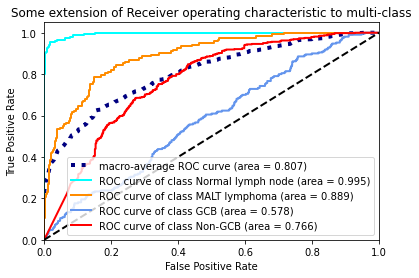

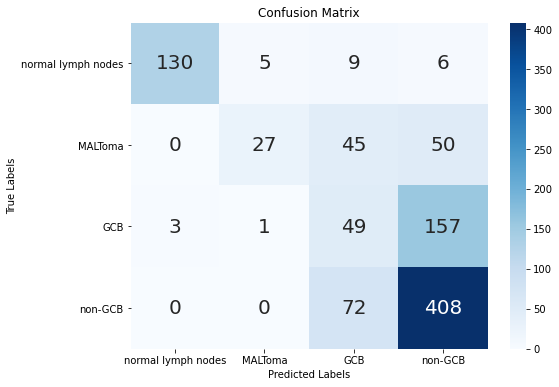

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.910 acc: 61.137
The current loss: 0.7232476352524441
trigger times: 0
epoch:2 loss: 0.702 acc: 69.934
The current loss: 0.5766234924099175
trigger times: 0
epoch:3 loss: 0.590 acc: 75.787
The current loss: 0.4893518203105723
trigger times: 0
epoch:4 loss: 0.502 acc: 79.553
The current loss: 0.39891979692793644
trigger times: 0
epoch:5 loss: 0.427 acc: 82.830
The current loss: 0.4110886930817035
trigger times: 1
epoch:6 loss: 0.378 acc: 84.603
The current loss: 0.2673279400001442
trigger times: 0
epoch:7 loss: 0.332 acc: 87.095
The current loss: 0.3314238936823359
trigger times: 1
epoch:8 loss: 0.296 acc: 88.701
The current loss: 0.20834184679114137
trigger times: 0
epoch:9 loss: 0.267 acc: 89.754
The current loss: 0.20812275076448467
trigger times: 0
epoch:10 loss: 0.245 acc: 90.695
The current loss: 0.1610839530961433
trigger times: 0
epoch:11 loss: 0.220 acc: 91.775
The current loss: 

epoch:93 loss: 0.011 acc: 99.649
The current loss: 0.0011563798440515519
trigger times: 0
epoch:94 loss: 0.010 acc: 99.668
The current loss: 0.0007163185404438076
trigger times: 0
epoch:95 loss: 0.011 acc: 99.658
The current loss: 0.0009506208601539874
trigger times: 1
epoch:96 loss: 0.011 acc: 99.686
The current loss: 0.00078267023060357
trigger times: 0
epoch:97 loss: 0.011 acc: 99.668
The current loss: 0.0008679689746997457
trigger times: 1
epoch:98 loss: 0.009 acc: 99.714
The current loss: 0.000614766827706547
trigger times: 0
epoch:99 loss: 0.007 acc: 99.806
The current loss: 0.0014723296385938224
trigger times: 1
epoch:100 loss: 0.011 acc: 99.668
The current loss: 0.000440499974723423
trigger times: 0
[[130   5   6   9]
 [  0  37  42  43]
 [  0   5  46 159]
 [  0   1  68 411]]


test accuracy : 0.649
test precison : 0.679
test recall : 0.561
test f : 0.589
AUC : 0.812
AUC for class 0: 0.999
AUC for class 1: 0.901
AUC for class 2: 0.569
AUC for class 3: 0.778


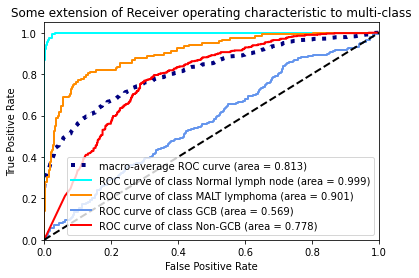

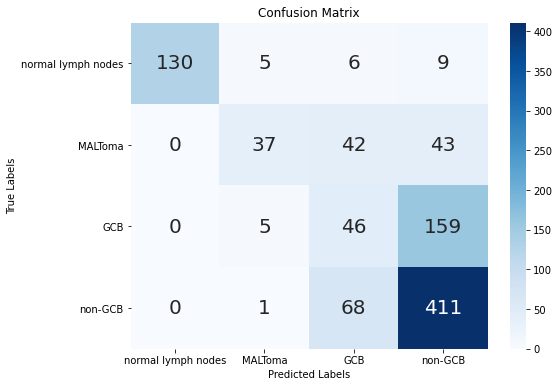

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3------------------------------------------------------------------------------
epoch:1 loss: 0.907 acc: 61.599
The current loss: 0.7294510586137792
trigger times: 0
epoch:2 loss: 0.695 acc: 70.848
The current loss: 0.5855614204086078
trigger times: 0
epoch:3 loss: 0.588 acc: 75.778
The current loss: 0.5473539961947013
trigger times: 0
epoch:4 loss: 0.509 acc: 79.479
The current loss: 0.42234781337627225
trigger times: 0
epoch:5 loss: 0.441 acc: 82.332
The current loss: 0.42833970282721306
trigger times: 1
epoch:6 loss: 0.382 acc: 84.907
The current loss: 0.2798110483994482
trigger times: 0
epoch:7 loss: 0.332 acc: 86.855
The current loss: 0.24894008086959948
trigger times: 0
epoch:8 loss: 0.303 acc: 88.286
The current loss: 0.2290212858794446
trigger times: 0
epoch:9 loss: 0.273 acc: 89.569
The current loss: 0.2550563542728634
trigger times: 1
epoch:10 loss: 0.247 acc: 90.529
The current loss: 0.16441360026534274
trigger times: 0
epoch:11 loss: 0.227 acc: 91.415
The current loss:

epoch:93 loss: 0.011 acc: 99.705
The current loss: 0.0049161129603096
trigger times: 1
epoch:94 loss: 0.013 acc: 99.658
The current loss: 0.0008956476450989618
trigger times: 0
epoch:95 loss: 0.010 acc: 99.677
The current loss: 0.002172232303287327
trigger times: 1
epoch:96 loss: 0.010 acc: 99.677
The current loss: 0.0021660167302655375
trigger times: 0
epoch:97 loss: 0.014 acc: 99.538
The current loss: 0.0020617390720741756
trigger times: 0
epoch:98 loss: 0.011 acc: 99.649
The current loss: 0.0019108218385996633
trigger times: 0
epoch:99 loss: 0.012 acc: 99.575
The current loss: 0.0006401786093030469
trigger times: 0
epoch:100 loss: 0.010 acc: 99.732
The current loss: 0.0009702191507628268
trigger times: 1
[[133   7   5   5]
 [  0  40  41  41]
 [  0   4  37 169]
 [  0   0  46 434]]


test accuracy : 0.669
test precison : 0.685
test recall : 0.574
test f : 0.597
AUC : 0.813
AUC for class 0: 0.997
AUC for class 1: 0.906
AUC for class 2: 0.568
AUC for class 3: 0.783


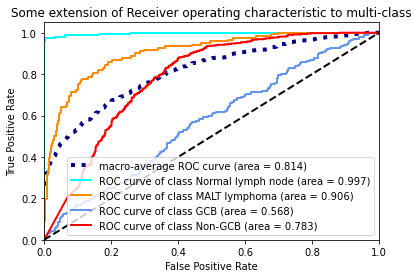

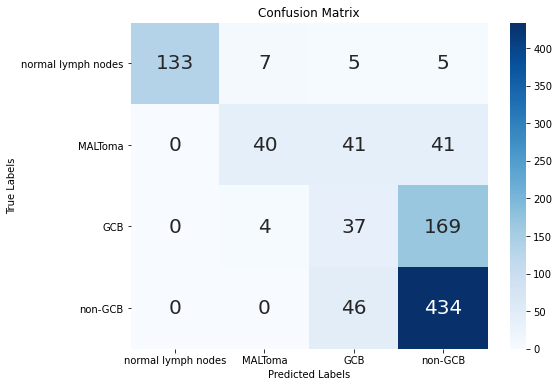

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4------------------------------------------------------------------------------
epoch:1 loss: 0.905 acc: 61.230
The current loss: 0.7295938876037181
trigger times: 0
epoch:2 loss: 0.699 acc: 70.405
The current loss: 0.6162822328955704
trigger times: 0
epoch:3 loss: 0.589 acc: 75.685
The current loss: 0.47313947766156633
trigger times: 0
epoch:4 loss: 0.510 acc: 79.332
The current loss: 0.4312344677485306
trigger times: 0
epoch:5 loss: 0.447 acc: 81.667
The current loss: 0.387127903403761
trigger times: 0
epoch:6 loss: 0.398 acc: 84.584
The current loss: 0.3207014994544683
trigger times: 0
epoch:7 loss: 0.354 acc: 86.006
The current loss: 0.28957633193854276
trigger times: 0
epoch:8 loss: 0.306 acc: 88.166
The current loss: 0.3552242946652366
trigger times: 1
epoch:9 loss: 0.275 acc: 89.310
The current loss: 0.7681112086029852
trigger times: 2
epoch:10 loss: 0.254 acc: 90.335
The current loss: 0.1700635690720763
trigger times: 0
epoch:11 loss: 0.226 acc: 91.286
The current loss: 0.

epoch:93 loss: 0.012 acc: 99.575
The current loss: 0.0011735681995856085
trigger times: 1
epoch:94 loss: 0.012 acc: 99.603
The current loss: 0.0016493652364748285
trigger times: 2
epoch:95 loss: 0.008 acc: 99.732
The current loss: 0.0027387157927097287
trigger times: 3
epoch:96 loss: 0.011 acc: 99.658
The current loss: 0.000703837100114547
trigger times: 0
epoch:97 loss: 0.012 acc: 99.585
The current loss: 0.0012347484923091894
trigger times: 1
epoch:98 loss: 0.012 acc: 99.640
The current loss: 0.0017017792882991236
trigger times: 2
epoch:99 loss: 0.012 acc: 99.622
The current loss: 0.014271148474185619
trigger times: 3
epoch:100 loss: 0.009 acc: 99.760
The current loss: 0.008194255323916712
trigger times: 0
[[122  17   9   2]
 [  0  58  38  26]
 [  0   1  56 153]
 [  0   1 123 356]]


test accuracy : 0.615
test precison : 0.666
test recall : 0.574
test f : 0.609
AUC : 0.808
AUC for class 0: 0.994
AUC for class 1: 0.939
AUC for class 2: 0.562
AUC for class 3: 0.735


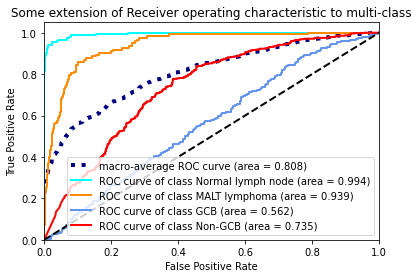

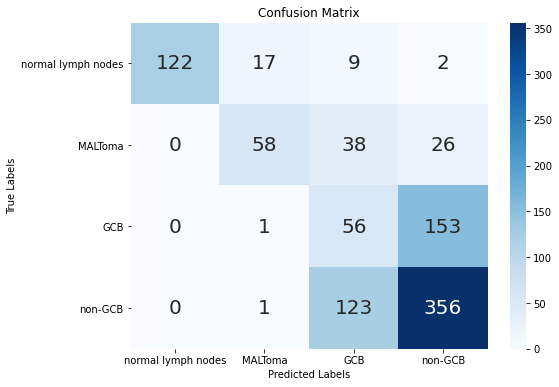

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 5------------------------------------------------------------------------------
epoch:1 loss: 0.900 acc: 62.476
The current loss: 0.7400991842040797
trigger times: 0
epoch:2 loss: 0.691 acc: 71.116
The current loss: 0.5748063348711724
trigger times: 0
epoch:3 loss: 0.593 acc: 75.408
The current loss: 0.490168717791461
trigger times: 0
epoch:4 loss: 0.513 acc: 78.806
The current loss: 0.4012087950590108
trigger times: 0
epoch:5 loss: 0.439 acc: 82.092
The current loss: 0.35013406530811086
trigger times: 0
epoch:6 loss: 0.387 acc: 84.658
The current loss: 0.31576964712514927
trigger times: 0
epoch:7 loss: 0.333 acc: 86.975
The current loss: 0.24911368436499082
trigger times: 0
epoch:8 loss: 0.300 acc: 88.646
The current loss: 0.25833156409108143
trigger times: 1
epoch:9 loss: 0.281 acc: 89.181
The current loss: 0.2963045272276638
trigger times: 2
epoch:10 loss: 0.253 acc: 90.344
The current loss: 0.1601692674081267
trigger times: 0
epoch:11 loss: 0.212 acc: 92.015
The current loss: 

epoch:93 loss: 0.016 acc: 99.511
The current loss: 0.0011403346249112152
trigger times: 2
epoch:94 loss: 0.011 acc: 99.658
The current loss: 0.0006845263918196189
trigger times: 0
epoch:95 loss: 0.013 acc: 99.603
The current loss: 0.0008915845698506045
trigger times: 1
epoch:96 loss: 0.011 acc: 99.594
The current loss: 0.0008825636146734602
trigger times: 0
epoch:97 loss: 0.010 acc: 99.705
The current loss: 0.0017698406918619737
trigger times: 1
epoch:98 loss: 0.009 acc: 99.742
The current loss: 0.001098578733160553
trigger times: 0
epoch:99 loss: 0.008 acc: 99.797
The current loss: 0.0005691701138908727
trigger times: 0
epoch:100 loss: 0.009 acc: 99.769
The current loss: 0.0010461986750582197
trigger times: 1
[[126  10  10   4]
 [  0  58  38  26]
 [  1   4  46 159]
 [  0   1  84 395]]


test accuracy : 0.650
test precison : 0.680
test recall : 0.589
test f : 0.621
AUC : 0.801
AUC for class 0: 0.994
AUC for class 1: 0.919
AUC for class 2: 0.527
AUC for class 3: 0.763


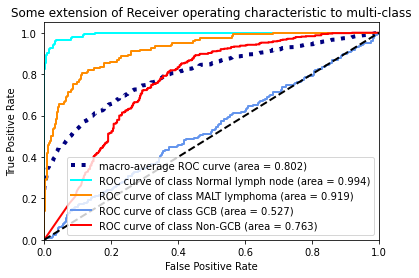

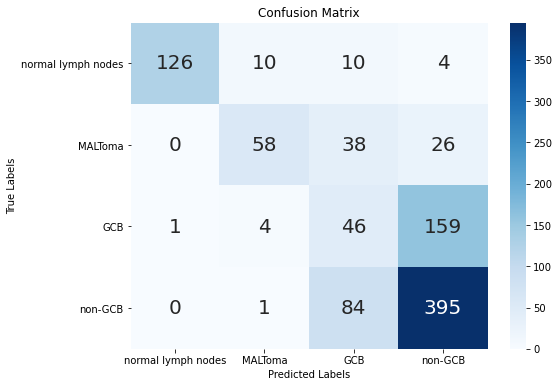

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 6------------------------------------------------------------------------------
epoch:1 loss: 0.896 acc: 62.485
The current loss: 0.7098643813710824
trigger times: 0
epoch:2 loss: 0.677 acc: 71.873
The current loss: 0.581428919049326
trigger times: 0
epoch:3 loss: 0.562 acc: 77.144
The current loss: 0.46000574169691466
trigger times: 0
epoch:4 loss: 0.485 acc: 80.412
The current loss: 0.4445668590017443
trigger times: 0
epoch:5 loss: 0.432 acc: 82.701
The current loss: 0.5183922399513995
trigger times: 1
epoch:6 loss: 0.379 acc: 84.750
The current loss: 0.28075615446128577
trigger times: 0
epoch:7 loss: 0.334 acc: 87.086
The current loss: 0.40333788499859735
trigger times: 1
epoch:8 loss: 0.300 acc: 88.304
The current loss: 0.22074852432199865
trigger times: 0
epoch:9 loss: 0.279 acc: 89.320
The current loss: 0.2962279769346107
trigger times: 1
epoch:10 loss: 0.237 acc: 91.332
The current loss: 0.16337177097232658
trigger times: 0
epoch:11 loss: 0.224 acc: 91.424
The current loss:

epoch:93 loss: 0.015 acc: 99.474
The current loss: 0.0027646887911651273
trigger times: 1
epoch:94 loss: 0.012 acc: 99.612
The current loss: 0.0006417259687997383
trigger times: 0
epoch:95 loss: 0.010 acc: 99.723
The current loss: 0.000990111449510107
trigger times: 1
epoch:96 loss: 0.008 acc: 99.760
The current loss: 0.0008976602459278992
trigger times: 0
epoch:97 loss: 0.012 acc: 99.649
The current loss: 0.0006006086613005598
trigger times: 0
epoch:98 loss: 0.009 acc: 99.695
The current loss: 0.0009710002343685817
trigger times: 1
epoch:99 loss: 0.011 acc: 99.594
The current loss: 0.000592947477054387
trigger times: 0
epoch:100 loss: 0.009 acc: 99.695
The current loss: 0.0006713814526686919
trigger times: 1
[[130  12   3   5]
 [  0  55  24  43]
 [  2   5  50 153]
 [  0   1  47 432]]


test accuracy : 0.693
test precison : 0.706
test recall : 0.614
test f : 0.640
AUC : 0.827
AUC for class 0: 0.994
AUC for class 1: 0.952
AUC for class 2: 0.577
AUC for class 3: 0.786


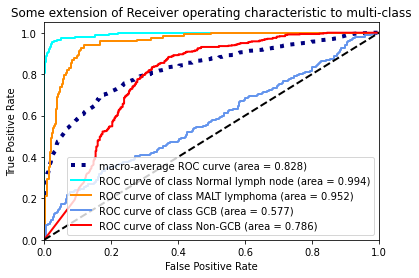

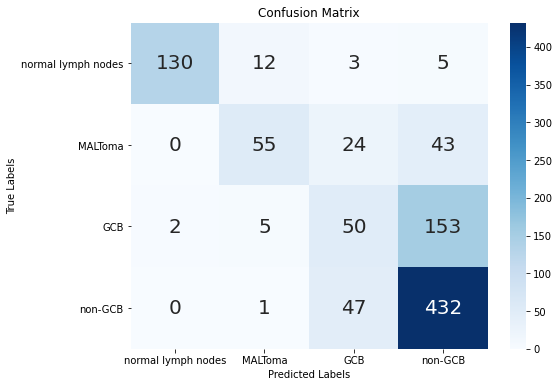

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 7------------------------------------------------------------------------------
epoch:1 loss: 0.909 acc: 60.971
The current loss: 0.7438914302769488
trigger times: 0
epoch:2 loss: 0.715 acc: 69.584
The current loss: 0.5950311028170551
trigger times: 0
epoch:3 loss: 0.601 acc: 75.298
The current loss: 0.48101849032011
trigger times: 0
epoch:4 loss: 0.513 acc: 79.756
The current loss: 0.41930936418328113
trigger times: 0
epoch:5 loss: 0.452 acc: 81.935
The current loss: 0.3246839975870893
trigger times: 0
epoch:6 loss: 0.395 acc: 84.307
The current loss: 0.2982404622023343
trigger times: 0
epoch:7 loss: 0.350 acc: 86.033
The current loss: 0.24433840931496914
trigger times: 0
epoch:8 loss: 0.309 acc: 87.787
The current loss: 0.23786011307198446
trigger times: 0
epoch:9 loss: 0.269 acc: 89.615
The current loss: 0.30285302545282244
trigger times: 1
epoch:10 loss: 0.256 acc: 89.763
The current loss: 0.15035301856179775
trigger times: 0
epoch:11 loss: 0.222 acc: 91.692
The current loss: 

KeyboardInterrupt: 

In [9]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # GoogleNet（Inception v1）モデルを事前学習済みモデルとしてロード
        model = models.googlenet(pretrained=True)

        # GoogleNetの最終層の入力特徴量数を取得
        num_ftrs = model.fc.in_features

        # 最終層を4クラスの出力に変更
        model.fc = nn.Linear(num_ftrs, 4)

        # すべての層を訓練可能に設定
        for param in model.parameters():
            param.requires_grad = True

        model = model.to(device)

        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()